In [1]:
import gymnasium as gym
import numpy as np
import time
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
import matplotlib.pyplot as plt
from cellitaire.environment.cellitaire_env import CellitaireEnv
from cellitaire.environment.rewards.reward import *

In [65]:
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states), np.array(self.actions), np.array(self.probs), np.array(self.vals), np.array(self.rewards), np.array(self.dones), batches
        
    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)
        self.actions.append(action)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

In [172]:
class ActorNetwork(nn.Module):
    def __init__(
        self, 
        n_actions, 
        input_dims, 
        alpha,
        chkpt_dir='tmp/ppo', 
        num_embeddings=53, 
        embedding_dim=30, 
        embeddings_in_state=85,
        num_hidden_layers=1,
        hidden_dim=256
    ):
        super(ActorNetwork, self).__init__()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        self.embedding_layer = nn.Embedding(num_embeddings, embedding_dim).to(self.device)
        self.embeddings_in_state = embeddings_in_state
        
        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo')
        self.actor = nn.Sequential(
            nn.Linear(input_dims[0] - self.embeddings_in_state + (self.embeddings_in_state * embedding_dim), hidden_dim),
            nn.ReLU()
        )
        
        for _ in range(num_hidden_layers):
            self.actor.append(nn.Linear(hidden_dim, hidden_dim))
            self.actor.append(nn.ReLU())
        
        self.actor.append(nn.Linear(hidden_dim, n_actions))
        self.actor.append(nn.Softmax(dim=-1))
        
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.to(self.device)
        
        self.n_actions = n_actions

    def forward(self, state):
        embeddings = self.embedding_layer(state[:, :self.embeddings_in_state].int()).view(state.shape[0], 1, -1)
        state = state.view(state.shape[0], 1, -1)[:, :, self.embeddings_in_state:]
        state = torch.concatenate((state, embeddings), dim=2)
        logits = self.actor(state)
        return logits

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))

In [187]:
class ActorNetwork(nn.Module):
    def __init__(
        self, 
        n_actions, 
        input_dims, 
        alpha,
        chkpt_dir='tmp/ppo', 
        num_embeddings=53, 
        embedding_dim=30, 
        embeddings_in_state=85,
        num_hidden_layers=1,
        hidden_dim=256
    ):
        super(ActorNetwork, self).__init__()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.embeddings_in_state = embeddings_in_state

        # Create embedding layer only if embeddings_in_state > 0.
        if embeddings_in_state > 0:
            self.embedding_layer = nn.Embedding(num_embeddings, embedding_dim).to(self.device)
            input_layer_dim = input_dims[0] - embeddings_in_state + (embeddings_in_state * embedding_dim)
        else:
            self.embedding_layer = None
            input_layer_dim = input_dims[0]

        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo')
        self.actor = nn.Sequential(
            nn.Linear(input_layer_dim, hidden_dim),
            nn.ReLU()
        )
        
        for _ in range(num_hidden_layers):
            self.actor.append(nn.Linear(hidden_dim, hidden_dim))
            self.actor.append(nn.ReLU())
        
        print(self.embedding_layer)
        
        self.actor.append(nn.Linear(hidden_dim, n_actions))
        self.actor.append(nn.Softmax(dim=-1))
        
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.to(self.device)
        self.n_actions = n_actions

    def forward(self, state):
        if self.embeddings_in_state > 0:
            arf = 
            embeddings = self.embedding_layer(state[:, :self.embeddings_in_state].int()).view(state.shape[0], 1, -1)
            state = state.view(state.shape[0], 1, -1)[:, :, self.embeddings_in_state:]

            
            # Concatenate the remaining state features with the flattened embeddings.
            new_state = torch.cat((state, embeddings), dim=2)
        else:
            new_state = state.view(state.shape[0], 1, -1)
        
        # Pass the processed state through the actor network.
        logits = self.actor(new_state)
        return logits

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))


In [150]:
class CriticNetwork(nn.Module):
    def __init__(
        self, 
        input_dims, 
        alpha, 
        fc1_dims=256, 
        fc2_dims=256, 
        chkpt_dir='tmp/ppo'
    ):
        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
        self.critic = nn.Sequential(
            nn.Linear(*input_dims, fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims, fc2_dims),
            nn.ReLU(),
            nn.Linear(fc2_dims, 1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        value = self.critic(state)
        return value

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))

In [151]:
class Agent:
    def __init__(
        self, 
        n_actions, 
        input_dims, 
        gamma=0.99, 
        alpha=0.0003, 
        gae_lambda=0.95,
        policy_clip=0.2, 
        batch_size=64, 
        n_epochs=10,
        num_hidden_layers_actor=1,
        hidden_dim_actor=256,
        embeddings_in_state_actor=85
    ):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda
        self.n_actions = n_actions

        self.actor = ActorNetwork(
            n_actions, 
            input_dims, 
            alpha, 
            num_hidden_layers=num_hidden_layers_actor, 
            hidden_dim=hidden_dim_actor,
            embeddings_in_state=embeddings_in_state_actor
        )
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)
       
    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print('... loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    '''
    def choose_action(self, observation, legal_actions):
        state = torch.tensor(np.array([observation]), dtype=torch.float).to(self.actor.device)
        
        dist = self.actor(state)
        legal_actions = torch.tensor(np.array(legal_actions)).to(self.actor.device)
        dist = Categorical(dist)
        value = self.critic(state)
        action = dist.sample()

        probs = torch.squeeze(dist.log_prob(action)).item()
        action = torch.squeeze(action).item()
        value = torch.squeeze(value).item()

        return action, probs, value
    '''
    
    '''
    def choose_action(self, observation, legal_actions):
        # Convert observation to tensor and send it to the actor's device.
        state = torch.tensor(np.array([observation]), dtype=torch.float).to(self.actor.device)

        # Get logits from the actor; assumed shape: (batch, 1, k)
        logits = self.actor(state)

        # Convert legal_actions to a tensor on the same device.
        legal_actions = torch.tensor(np.array(legal_actions)).to(self.actor.device)

        # Mask logits so that only legal actions remain.
        # If logits has shape (n, 1, k), we index into the third dimension.
        masked_logits = logits[:, 0, legal_actions]  # shape: (n, len(legal_actions))

        # Build a Categorical using the masked logits.
        dist = Categorical(logits=masked_logits)

        # Get the value estimate from the critic.
        value = self.critic(state)

        # Sample an action index from the distribution.
        # This gives a relative index in the filtered (legal) logits.
        relative_index = dist.sample()  # shape: (n,)

        # Map the relative index back to the original action space.
        action = legal_actions[relative_index]

        # Compute the log probability for the sampled action.
        probs = torch.squeeze(dist.log_prob(relative_index)).item()

        # Squeeze and convert to Python scalars.
        action = torch.squeeze(action).item()
        value = torch.squeeze(value).item()

        return action, probs, value
    '''
    
    def choose_action(self, observation, legal_actions=None):
        state = torch.tensor(np.array([observation]), dtype=torch.float).to(self.actor.device)

        # Get logits from the actor; assumed shape: (n, 1, k)
        logits = self.actor(state)

        # If legal_actions is provided, mask the logits to include only those actions.
        if legal_actions is not None:
            legal_actions = torch.tensor(np.array(legal_actions)).to(self.actor.device)
            masked_logits = logits[:, 0, legal_actions]  # shape: (n, len(legal_actions))
            dist = Categorical(logits=masked_logits)
        else:
            # Use all logits if no legal actions mask is provided.
            full_logits = logits.squeeze(1)  # shape: (n, k)
            dist = Categorical(logits=full_logits)

        value = self.critic(state)

        # Sample an action index from the distribution.
        sampled_index = dist.sample()  # shape: (n,)

        # Map back to the original action if a mask was applied.
        if legal_actions is not None:
            action = legal_actions[sampled_index]
        else:
            action = sampled_index

        # Get the log probability of the sampled action.
        log_prob = torch.squeeze(dist.log_prob(sampled_index)).item()

        # Squeeze and convert to Python scalars.
        action = torch.squeeze(action).item()
        value = torch.squeeze(value).item()

        return action, log_prob, value


    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
            reward_arr, dones_arr, batches = \
                    self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = torch.tensor(advantage).to(self.actor.device)

            values = torch.tensor(values).to(self.actor.device)
            for batch in batches:
                states = torch.tensor(state_arr[batch], dtype=torch.float).to(self.actor.device)
                old_probs = torch.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = torch.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                dist = Categorical(dist)
                critic_value = self.critic(states)

                critic_value = torch.squeeze(critic_value)
                
                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                #prob_ratio = (new_probs - old_probs).exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = torch.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -torch.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.clear_memory()               

In [152]:
test_reward = CombinedReward([
    PlacedCardInFoundationReward(weight=2),
    WinReward(),
    ConstantReward(weight=-0.1),
    #PlayedLegalMoveReward(weight=1),
    PeriodicPlacedCardInFoundationReward(weight=2, reward_period=3)
])

In [153]:
print([reward.weight for reward in test_reward.rewards_list])

[2, 1000000, -0.1, 2]


In [193]:
board_rows = 7
board_cols = 12
num_reserved = 6
env = CellitaireEnv(test_reward, rows=board_rows, cols=board_cols, num_reserved=num_reserved)

In [195]:
N = 20
batch_size = 5
n_epochs = 5
alpha = 0.0003
num_hidden_layers_actor=3
hidden_dim_actor=256
#embeddings_in_state_actor=0
embeddings_in_state_actor= board_rows * board_cols + 1
agent = Agent(
    n_actions=env.action_space.n, 
    input_dims=(7 * 12 + 6,), 
    batch_size=batch_size, 
    alpha=alpha, 
    n_epochs=n_epochs,
    num_hidden_layers_actor=num_hidden_layers_actor,
    hidden_dim_actor=hidden_dim_actor,
    embeddings_in_state_actor=embeddings_in_state_actor
)

n_games = 15000

best_score = -1000
score_history = []

learn_iters = 0
avg_score = 0
n_steps = 0

for i in range(n_games):
    observation, reward, done, truncated, info = env.reset()
    done = False
    score = 0
    while (not done) and (not truncated):
        legal_actions = env.get_legal_actions_as_int()
        action, prob, val = agent.choose_action(observation, legal_actions)
        observation_, reward, done, truncated, info = env.step(action)
        n_steps += 1
        score += reward
        agent.remember(observation, action, prob, val, reward, done)
        if n_steps % N == 0:
            agent.learn()
            learn_iters += 1
        observation = observation_
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()
    
    print(f'episode {i:>5} | score {score:>6.1f} | recent avg {avg_score:>6.1f} | legal moves {env.num_moves:>3} | cards saved {env.game.foundation.total_cards():>2} | done {done}')

Embedding(53, 30)
... saving models ...
episode     0 | score   43.9 | recent avg   43.9 | legal moves 301 | cards saved 22 | done False
episode     1 | score    3.4 | recent avg   23.6 | legal moves   6 | cards saved  1 | done True
episode     2 | score    2.0 | recent avg   16.4 | legal moves  20 | cards saved  1 | done True
episode     3 | score    5.2 | recent avg   13.6 | legal moves 148 | cards saved  6 | done True
episode     4 | score   10.4 | recent avg   13.0 | legal moves  36 | cards saved  4 | done True
episode     5 | score    0.2 | recent avg   10.8 | legal moves  38 | cards saved  1 | done True
episode     6 | score   37.9 | recent avg   14.7 | legal moves 301 | cards saved 20 | done False
episode     7 | score    0.4 | recent avg   12.9 | legal moves  36 | cards saved  1 | done True
episode     8 | score   -1.8 | recent avg   11.3 | legal moves  18 | cards saved  0 | done True
episode     9 | score   32.8 | recent avg   13.4 | legal moves 272 | cards saved 18 | done Tru

episode    85 | score    5.0 | recent avg   11.3 | legal moves  30 | cards saved  2 | done True
episode    86 | score    6.0 | recent avg   11.2 | legal moves  40 | cards saved  3 | done True
episode    87 | score   21.6 | recent avg   11.4 | legal moves 264 | cards saved 14 | done True
episode    88 | score   13.4 | recent avg   11.4 | legal moves 166 | cards saved  9 | done True
episode    89 | score   33.9 | recent avg   11.6 | legal moves 301 | cards saved 19 | done False
episode    90 | score   49.3 | recent avg   12.0 | legal moves 287 | cards saved 23 | done True
episode    91 | score    5.6 | recent avg   12.0 | legal moves  24 | cards saved  2 | done True
episode    92 | score   33.9 | recent avg   12.2 | legal moves 301 | cards saved 19 | done False


KeyboardInterrupt: 

In [ ]:
plt.plot(torch.tensor(score_history, dtype=torch.float).view(-1, 100).mean(1))

In [190]:
env = gym.make("CartPole-v1", render_mode="human")
env.reset()
env.render()

None
... saving models ...
episode 0 score 13.0 avg score 13.0 time_steps 13 learning_steps 0
... saving models ...
episode 1 score 19.0 avg score 16.0 time_steps 32 learning_steps 1
episode 2 score 12.0 avg score 14.7 time_steps 44 learning_steps 2
episode 3 score 12.0 avg score 14.0 time_steps 56 learning_steps 2
... saving models ...
episode 4 score 36.0 avg score 18.4 time_steps 92 learning_steps 4
episode 5 score 14.0 avg score 17.7 time_steps 106 learning_steps 5
... saving models ...
episode 6 score 26.0 avg score 18.9 time_steps 132 learning_steps 6
episode 7 score 17.0 avg score 18.6 time_steps 149 learning_steps 7
... saving models ...
episode 8 score 29.0 avg score 19.8 time_steps 178 learning_steps 8
... saving models ...
episode 9 score 36.0 avg score 21.4 time_steps 214 learning_steps 10
... saving models ...
episode 10 score 39.0 avg score 23.0 time_steps 253 learning_steps 12
episode 11 score 15.0 avg score 22.3 time_steps 268 learning_steps 13
episode 12 score 11.0 avg

episode 111 score 20.0 avg score 24.8 time_steps 2744 learning_steps 137
... saving models ...
episode 112 score 33.0 avg score 25.0 time_steps 2777 learning_steps 138
... saving models ...
episode 113 score 11.0 avg score 25.0 time_steps 2788 learning_steps 139
... saving models ...
episode 114 score 57.0 avg score 25.4 time_steps 2845 learning_steps 142
... saving models ...
episode 115 score 51.0 avg score 25.8 time_steps 2896 learning_steps 144
episode 116 score 19.0 avg score 25.8 time_steps 2915 learning_steps 145
... saving models ...
episode 117 score 52.0 avg score 26.1 time_steps 2967 learning_steps 148
... saving models ...
episode 118 score 37.0 avg score 26.4 time_steps 3004 learning_steps 150
... saving models ...
episode 119 score 31.0 avg score 26.6 time_steps 3035 learning_steps 151
... saving models ...
episode 120 score 20.0 avg score 26.6 time_steps 3055 learning_steps 152
... saving models ...
episode 121 score 63.0 avg score 27.1 time_steps 3118 learning_steps 155

episode 214 score 32.0 avg score 30.1 time_steps 5852 learning_steps 292
episode 215 score 40.0 avg score 30.0 time_steps 5892 learning_steps 294
episode 216 score 23.0 avg score 30.0 time_steps 5915 learning_steps 295
episode 217 score 36.0 avg score 29.8 time_steps 5951 learning_steps 297
episode 218 score 33.0 avg score 29.8 time_steps 5984 learning_steps 299
episode 219 score 20.0 avg score 29.7 time_steps 6004 learning_steps 300
episode 220 score 28.0 avg score 29.8 time_steps 6032 learning_steps 301
episode 221 score 15.0 avg score 29.3 time_steps 6047 learning_steps 302
episode 222 score 31.0 avg score 29.5 time_steps 6078 learning_steps 303
episode 223 score 38.0 avg score 29.6 time_steps 6116 learning_steps 305
episode 224 score 12.0 avg score 29.6 time_steps 6128 learning_steps 306
episode 225 score 27.0 avg score 29.7 time_steps 6155 learning_steps 307
episode 226 score 11.0 avg score 29.4 time_steps 6166 learning_steps 308
episode 227 score 20.0 avg score 29.4 time_steps 61

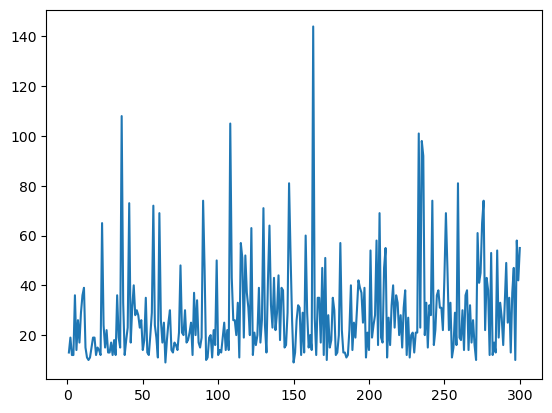

In [192]:
N = 20
batch_size = 5
n_epochs = 4
alpha = 0.0003
embeddings_in_state_actor=0
agent = Agent(
    n_actions=env.action_space.n, 
    input_dims=env.observation_space.shape, 
    batch_size=batch_size, 
    alpha=alpha, 
    n_epochs=n_epochs,
    embeddings_in_state_actor=embeddings_in_state_actor
)

n_games = 300

best_score = -1000
score_history = []

learn_iters = 0
avg_score = 0
n_steps = 0

for i in range(n_games):
    (observation, _) = env.reset()
    done = False
    score = 0
    while not done:
        action, prob, val = agent.choose_action(observation)
        observation_, reward, done, _, info = env.step(action)
        n_steps += 1
        score += reward
        agent.remember(observation, action, prob, val, reward, done)
        if n_steps % N == 0:
            agent.learn()
            learn_iters += 1
        observation = observation_
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()

    print('episode', i, 'score %.1f' % score,'avg score %.1f' % avg_score, 'time_steps', n_steps, 'learning_steps', learn_iters)
x = [i + 1 for i in range(len(score_history))]
plt.plot(x, score_history)
env.close()

In [32]:
%pip install -e ../.

Obtaining file:///P:/repos/cellitaire-rl
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for cellitaire (pyproject.toml): started
  Building editable for cellitaire (pyproject.toml): finished with status 'done'
  Created wheel for cellitaire: filename=cellitaire-0.0.1-0.editable-py3-none-any.whl size=1307 sha256=abd36cab9a29c4bae2fb4bc6203232d252c22704dd97daeba65e075a317e3d22
  Stored in directory: C:\Users\Noe\AppData\Local\Temp\pip-ephem-wheel-cache-14ynjh2i\wheels\76\88\96\576254946bf13aa1d012dfa539e7e5e1fddd6ac7e334da0df2


In [3]:
%pip install gymnasium[classic-control]

  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [86 lines of output]
  
  
  WARNING, No "Setup" File Exists, Running "buildconfig/config.py"
  Using WINDOWS configuration...
  
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
      exec(compile('''
      ~~~~^^^^^^^^^^^^
      # This is <pip-setuptools-caller> -- a caller that pip uses to run setup.py
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
      ...<31 lines>...
      exec(compile(setup_py_code, filename, "exec"))
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
      ''' % ('C:\\Users\\Noe\\AppData\\Local\\Temp\\pip-install-eoyw7vpr\\pygame_967dc80c3fe74667b8820019c1335dad\\setup.py',), "<pip-setuptools-caller>", "exec"))
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "<


  Using cached pygame-2.1.3.tar.gz (12.8 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


In [4]:
%pip install pygame

   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------- ----------- 7.6/10.6 MB 42.4 MB/s eta 0:00:01
   ---------------------------------------- 10.6/10.6 MB 37.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
